In [4]:
import math
import numpy as np
from matplotlib import pyplot as plt
import copy
import gif
from IPython.display import Image


In [7]:
def animate(data, j, patch, head, joints):
    first = []
    second = []
    for i in joints:
        first.append(data[j][0][i])
        second.append(data[j][1][i])
    a = np.array([first, second])
    a = np.transpose(a)
    patch.set_xy(a)
    head.center = (data[j][0][5], data[j][1][5])
    return patch, head

# To create a gif image
@gif.frame
def plot_samples_normal(data, j):
    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(-0.1, 3))


    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor="k")
    head = plt.Circle((0, 0), radius=0.15, fc="k", ec="k")
    ax.add_patch(patch)
    ax.add_patch(head)
    plt.title(f"total_distance: {data[j][0][5]:.2f}")
    animate(data, j, patch, head, joints)
    # ax.Line2D([-0.5, 0], [10, 0], color='black')

    step_size = 11 / len(data)

    # Add a progress bar rectangle at the bottom
    progress_bar_height = 0.1
    progress_bar_y = -0.1  # Position of the progress bar on the y-axis
    progress_bar = plt.Rectangle((-1, progress_bar_y), step_size*j, progress_bar_height, color='blue')
    ax.add_patch(progress_bar)

    # Add a border for the progress bar
    progress_bar_border = plt.Rectangle((-1, progress_bar_y), 11, progress_bar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(progress_bar_border)



In [10]:
# plan is an array of 40 floating point numbers
def sim(plan):
    """
    Simulates the motion of a multi-jointed body based on a given plan.

    Parameters:
    plan (list of float): A list of control parameters for the simulation. Each element should be between -1 and 1.

    Returns:
    tuple:
        - data (list of list of list of float): A list of positions of the body parts at each time step. Each position is a list of two lists, representing the x and y coordinates of the body parts.
        - final_position (float): The final x-coordinate of the head (body part 5).

    The simulation involves:
    - Adjusting the control parameters to be within the range [-1, 1].
    - Initializing physical properties such as mass, edge lengths, spring constants, and damping factors.
    - Iteratively updating the positions and velocities of the body parts based on forces, torques, and constraints.
    - Handling contact with the ground and applying friction.
    - Recording the positions of the body parts at each time step.
    - Returning the recorded data and the final x-coordinate of the head.
    """
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1 # time step
    friction = 1.0 # friction coefficient
    gravity = 0.1 # gravity constant
    mass = [30, 10, 5, 10, 5, 10] # mass of body parts
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9] # edge lengths
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]    # spring constants
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]   # damping factors
    anglessp = [20.0, 20.0, 10.0, 10.0] # angular spring constants
    anglesf = [8.0, 8.0, 4.0, 4.0]  # angular damping factors

    edge = [(0, 1), (1, 2), (0, 3), (3, 4), (0, 5)] # edges
    angles = [(4, 0), (4, 2), (0, 1), (2, 3)] # angles

    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    p = [[0, 0, -0.25, 0.25, 0.25, 0.15], [1, 0.5, 0, 0.5, 0, 1.9]]

    spin = 0.0
    maxspin = 0.0
    lastang = 0.0

    data = []

    for j in range(20): # 20 time steps
        for k in range(10): # 10 substeps
            lamb = 0.05 + 0.1 * k 
            t0 = 0.5
            if j > 0:
                t0 = plan[2 * j - 2]
            t0 *= 1 - lamb
            t0 += plan[2 * j] * lamb

            t1 = 0.0
            if j > 0:
                t1 = plan[2 * j - 1]
            t1 *= 1 - lamb
            t1 += plan[2 * j + 1] * lamb

            contact = [False, False, False, False, False, False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8 + t0), -(2.8 - t0), -(1 - t1) * 0.9, -(1 + t1) * 0.9] 

            disp = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            dist = [0, 0, 0, 0, 0]
            dispn = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]] - p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]] - p[1][edge[z][0]]
                dist[z] = (
                    math.sqrt(disp[0][z] * disp[0][z] + disp[1][z] * disp[1][z]) + 0.01
                )
                inv = 1.0 / dist[z]
                dispn[0][z] = disp[0][z] * inv
                dispn[1][z] = disp[1][z] * inv 

            dispv = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            distv = [0, 0, 0, 0, 0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2 * (disp[0][z] * dispv[0][z] + disp[1][z] * dispv[1][z])

            forceedge = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                c = (edgel[z] - dist[z]) * edgesp[z] - distv[z] * edgef[z]
                forceedge[0][z] = c * dispn[0][z]
                forceedge[1][z] = c * dispn[1][z]

            edgeang = [0, 0, 0, 0, 0]
            edgeangv = [0, 0, 0, 0, 0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z] * disp[1][z] - dispv[1][z] * disp[0][z]) / (
                    dist[z] * dist[z]
                )

            inc = edgeang[4] - lastang
            if inc < -math.pi:
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - 0.005 * (k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0, 0, 0, 0]
            for z in range(4): 
                angv[z] = edgeangv[angles[z][1]] - edgeangv[angles[z][0]]

            angf = [0, 0, 0, 0]
            for z in range(4):
                ang = edgeang[angles[z][1]] - edgeang[angles[z][0]] - anglesl[z]
                if ang > math.pi:
                    ang -= 2 * math.pi
                elif ang < -math.pi:
                    ang += 2 * math.pi
                m0 = dist[angles[z][0]] / edgel[angles[z][0]]
                m1 = dist[angles[z][1]] / edgel[angles[z][1]]
                angf[z] = ang * anglessp[z] - angv[z] * anglesf[z] * min(m0, m1)

            edgetorque = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                inv = 1.0 / (dist[z] * dist[z])
                edgetorque[0][z] = -disp[1][z] * inv
                edgetorque[1][z] = disp[0][z] * inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z] * edgetorque[0][i0]
                forceedge[1][i0] += angf[z] * edgetorque[1][i0]
                forceedge[0][i1] -= angf[z] * edgetorque[0][i1]
                forceedge[1][i1] -= angf[z] * edgetorque[1][i1]

            f = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity * mass[z]
                invm = 1.0 / mass[z]
                v[0][z] += f[0][z] * dt * invm
                v[1][z] += f[1][z] * dt * invm

                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z] * s < fric * friction:
                        v[0][z] = 0
                    else:
                        v[0][z] -= fric * friction * s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt

            data.append(copy.deepcopy(p))

            if contact[0] or contact[5]:
                return data, p[0][5]
    return data, p[0][5]

2.8700786025602474
4.030311146901732
4.354968819756102
5.214759453658421
5.41611859912018
5.458909847453043
5.458909847453043
5.473238717306702
5.481967768898222
5.540472501232983
5.540472501232983
5.588484372489156
5.672081860984048
5.721207709657792
5.736664021719075
Total Distance =  5.736664021719075


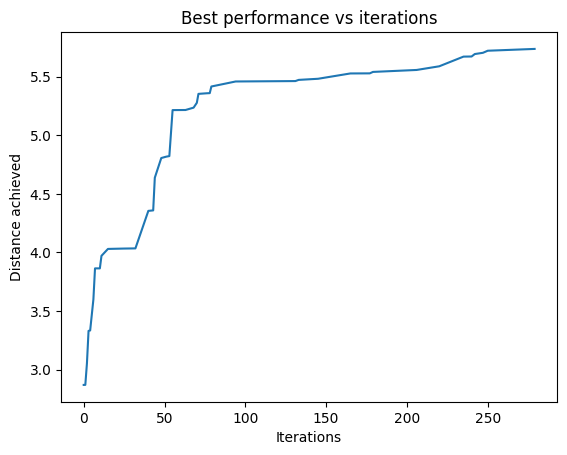

In [99]:
# A genetic algorithm (an evolutionary algorithm inspired by nature)

def mutate_plans(plans, mutation_rate, avoid_i):
    gene_len = len(plans[0])
    for i in range(len(plans)):
        if i == avoid_i:
            continue
        plan = plans[i]
        mutation_spots = np.random.rand(gene_len)
        mutation_spots[mutation_spots<mutation_rate] = 1
        mutation_spots[mutation_spots!=1] = 0
        non_mut_spots =  np.ones(gene_len) - mutation_spots

        random_plan = [np.random.uniform(-1, 1) for i in range(gene_len)]

        new_plan = plan * non_mut_spots + random_plan * mutation_spots
        plans[i] = new_plan

def crossover(plans, crossover_prob):
    gene_len = len(plans[0])
    for i in range(len(plans)//2):
        prob = np.random.rand()
        if prob < crossover_prob:
            plan1 = plans[2*i]
            plan2 = plans[2*i+1]
            cut_off_point = np.random.randint(gene_len)

            plan1[cut_off_point:] = plan2[cut_off_point:]
            plan2[:cut_off_point] = plan1[:cut_off_point]

def find_best_plan(plans):
    best_i = 0
    best_dist = -100 # very bad
    for i in range(len(plans)):
        plan = plans[i]
        _, total_distance = sim(plan)
        if total_distance > best_dist:
            best_i = i
            best_dist = total_distance
    return best_i, best_dist

def set_to_best_plan(plans, best_plan, probability):
    for i in range(len(plans)):
        prob = np.random.rand()
        if prob < probability:
            plans[i] = list(best_plan)

plans = []
best_plan = [np.random.uniform(-1, 1) for i in range(40)]
nr_plans = 50
nr_iterations = 300

for i in range(nr_plans):
    plan = [np.random.uniform(-1, 1) for i in range(40)]
    plans.append(plan)

best_ever_plan = None
best_ever_dist = -100
new_best_indices = []
best_ever_dist_list = []

for i in range(nr_iterations):

    best_i, best_dist = find_best_plan(plans)

    if best_dist > best_ever_dist:
        best_ever_dist = best_dist
        best_ever_plan = list(plans[best_i]) # creates a copy
        best_ever_dist_list.append(best_dist)
        new_best_indices.append(i)

    if i%20==0:
        print(best_dist)

    set_to_best_plan(plans, best_plan=best_ever_plan, probability=0.05)

    mutate_plans(plans, mutation_rate=0.03, avoid_i=best_i) # keep one example of the best one

    crossover(plans, crossover_prob=0.1)

darwins_plan = list(best_ever_plan)

data, total_distance = sim(darwins_plan)
print("Total Distance = ", total_distance)

plt.plot(new_best_indices, best_ever_dist_list)
plt.title("Best performance vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Distance achieved")
plt.show()


Total Distance =  5.736664021719075
plan =  [-0.704145366290791, 0.9189227137300211, 0.6019297050191552, -0.854984238644187, -0.7326561601658907, -0.9540277720066932, 0.18327264052844838, 0.32949187182525774, 0.88120127319399, 0.9965878232803769, -0.08537306062738148, -0.680868930451636, -0.4808752596876178, -0.17957860823466265, -0.29916658182493294, -0.8091128905851801, 0.5923422261592968, 0.7432395511556884, -0.04015647053907068, 0.8631138487752008, 0.5245148220563214, 0.23682399207846827, 0.8644549330106495, 0.9888862945395118, -0.8383027596950443, -0.8430649500011091, 0.016072383118096, -0.7514758000630328, 0.42437829182152, 0.7689465595098712, -0.6789326895886343, -0.6867881836145093, -0.09577281315803154, -0.7599031846495059, -0.3924811787783493, -0.8886181028132858, 0.25947918027384587, -0.6492864997505388, 0.03120057108654506, -0.47088802887791825]


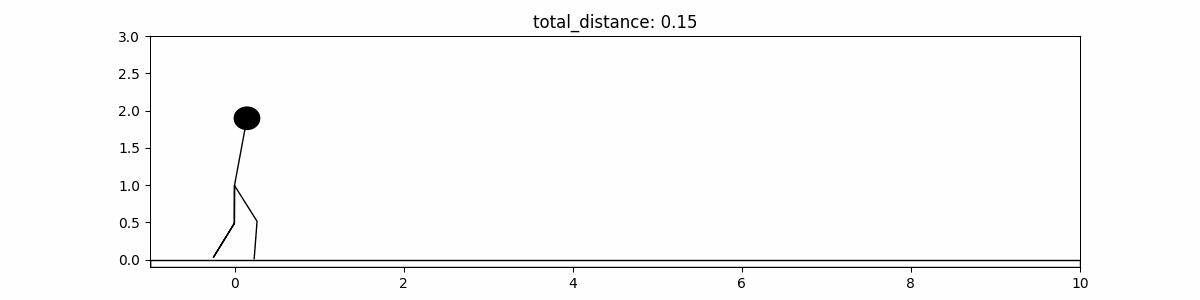

In [100]:
###########
# The following code is given as an example to store a video of the run and to display
# the run in a graphics window. You will treat sim(plan) as a black box objective
# function and maximize it.
###########
data, total_distance = sim(darwins_plan)
print("Total Distance = ", total_distance)
print("plan = ", darwins_plan)

# Create a gif
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation.gif", duration=40)
Image(filename="animation.gif")

-0.29864375839201157
0.5341283219351156
1.0637386024010496
4.169544576179461
4.509450740372513
4.770840933238534
4.944643381006472
5.139602784715647
5.309264356913877
5.435962195240885
5.485173098531582
5.505313472371845
5.52699207041007
5.562876370907798
5.60693746686604
Total Distance =  5.643178258602484


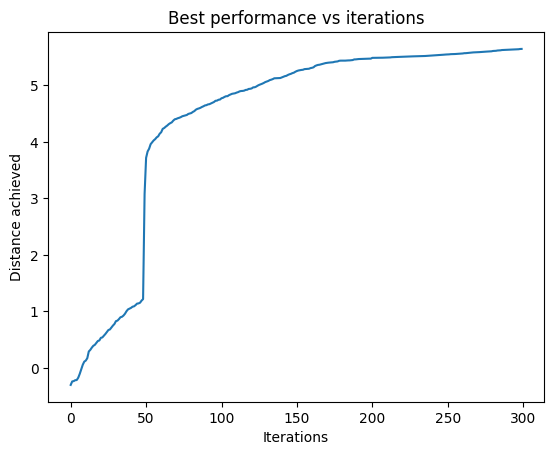

In [94]:
# A variant of a gradient based method

def take_one_step(plan, step_size):
    #new_plan = list(plan)
    _, old_distance = sim(plan)
    for i in range(len(plan)):
        old_param = plan[i]
        forward_param = min(old_param + step_size, 1) # the paramters have to be in range [-1,1]
        backward_param = max(old_param - step_size, -1)

        plan[i] = forward_param
        _, forward_dist = sim(plan)
        plan[i] = backward_param
        _, backward_dist = sim(plan)
        
        if forward_dist > old_distance:
            plan[i] = forward_param
        elif backward_dist > old_distance:
            plan[i] = backward_param
        else:
            plan[i] = old_param

    return plan #new_plan


#plan = list(darwins_plan)  
plan = [np.random.uniform(-1, 1) for i in range(40)]

nr_iterations = 300

best_ever_dist = -100
new_best_indices = []
best_ever_dist_list = []

for i in range(nr_iterations):

    plan = take_one_step(plan, step_size=0.01)

    _, new_dist = sim(plan)

    if new_dist > best_ever_dist:
        new_best_indices.append(i)
        best_ever_dist_list.append(new_dist)
        best_ever_dist = new_dist

    if i % 20 == 0:
        print(best_ever_dist)

gradient_plan = list(plan)

_, total_distance = sim(gradient_plan)
print("Total Distance = ", total_distance)

plt.plot(new_best_indices, best_ever_dist_list)
plt.title("Best performance vs iterations")
plt.xlabel("Iterations")
plt.ylabel("Distance achieved")
plt.show()


Total Distance =  5.643178258602484
plan =  [0.5588413010964497, 0.5862141034363186, 0.49021203722375367, 0.5318597016809559, -0.37792020706690677, 0.4864383562255785, 0.9099999999999999, 1, 1, -0.10841931327286261, 0.8941293564254982, 0.5807206272789199, -0.40875043616145734, 0.49722962312118024, 1, 0.8599999999999999, 0.95, 0.5139380973063082, 0.97, 0.10314497829865375, 0.4029734445234853, -0.6480515783684111, 1, 1, -0.2452963116796854, 1, 0.97, 0.47999999999999954, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


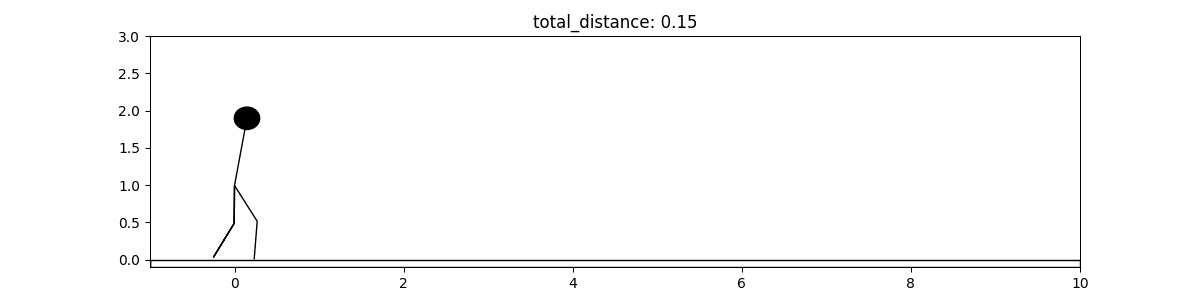

In [98]:
data, total_distance = sim(gradient_plan)
print("Total Distance = ", total_distance)
print("plan = ", gradient_plan)

frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation.gif", duration=40)
Image(filename="animation.gif")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4c0d3fbd-b6ee-49fa-994a-0a7a4a6dd817' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>